In [53]:
import requests
import pandas as pd
from sklearn import svm
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [121]:
#liste des gares API SNCF
url_proprete = "https://ressources.data.sncf.com/api/v2/catalog/datasets/proprete-en-gare/exports/json?limit=-1&offset=0&timezone=UTC"
proprete = requests.get(url_proprete)
wb_proprete = proprete.json()

df_proprete = pd.DataFrame(wb_proprete)
df_proprete

,mois,uic,nom_gare,nombre_de_non_conformites,nombre_d_observations,taux_de_conformite
0,2019-05,0087753285,Pas des Lanciers,39,1404,97.222222
1,2019-05,0087753491,Croix Sainte,39,624,93.750000
2,2019-05,0087753566,Carry-le-Rouet,156,2457,93.650794
3,2019-05,0087753582,Niolon,78,897,91.304348
4,2019-05,0087753657,Arles,570,12388,95.398773
...,...,...,...,...,...,...
58121,2019-05,0087751370,Meyrargues,38,2926,98.701299
58122,2019-05,0087751420,Gardanne,152,2888,94.736842
58123,2019-05,0087751719,La Pomme,38,1976,98.076923
58124,2019-05,0087751743,La Penne-sur-Huveaune,38,3268,98.837209


In [122]:
df_proprete['uic'] = pd.to_numeric(df_proprete['uic'])

In [123]:
url_freq_gares = "https://ressources.data.sncf.com/api/v2/catalog/datasets/frequentation-gares/exports/json?limit=-1&offset=0&timezone=UTC"
freq_gares = requests.get(url_freq_gares)
wb_freq_gares = freq_gares.json()

df_freq_gares = pd.DataFrame(wb_freq_gares)
df_freq_gares.rename(columns = {'code_uic_complet':'uic'}, inplace = True)
df_freq_gares

,nom_gare,uic,code_postal,segmentation_drg,total_voyageurs_2021,total_voyageurs_non_voyageurs_2021,total_voyageurs_2020,total_voyageurs_non_voyageurs_2020,total_voyageurs_2019,total_voyageurs_non_voyageurs_2019,total_voyageurs_2018,total_voyageurs_non_voyageurs_2018,totalvoyageurs2017,total_voyageurs_non_voyageurs_2017,total_voyageurs_2016,total_voyageurs_non_voyageurs_2016,total_voyageurs_2015,total_voyageurs_non_voyageurs_2015
0,Abbaretz,87481614,44170,c,27466,27466,22773,22773,38473,38473,38027,38027,35637,35637,33021,33021,35989,35989
1,Agay,87757559,83530,c,25094,25094,15390,15390,22284,22284,15093,15093,14154,14154,19240,19240,19121,19121
2,Aigueperse,87734129,63260,c,55143,55143,50677,50677,75954,75954,70745,70745,77218,77218,78088,78088,75873,75873
3,Aigues-Mortes,87775858,30220,c,8201,8201,5683,5683,6146,6146,5311,5311,4822,4822,3546,3546,3917,3917
4,Aime - La Plagne,87741769,73210,b,60161,75201,71603,89504,105825,132281,104267,130333,106398,132998,105331,131663,101243,126554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,Épluches,87276147,95310,c,64775,64775,33122,33122,82821,82821,87088,87088,74693,74693,70353,70353,68305,68305
2966,Étainhus - Saint-Romain,87413328,76430,c,49644,49644,42897,42897,63166,63166,51343,51343,53959,53959,55746,55746,62116,62116
2967,Étang-sur-Arroux,87694141,71190,c,91060,91060,76286,76286,76539,76539,67299,67299,72528,72528,71592,71592,81646,81646
2968,Évian-les-Bains,87745679,74500,b,167516,209395,116019,145024,171310,214137,153441,191801,184932,231165,173811,217264,187774,234717


In [124]:
df_freq_gares['uic'] = pd.to_numeric(df_freq_gares['uic'])

In [127]:
#on va observer la proprete des gares pour lesquelles on a les donnees, et le df de la frequentation contient moins de donnees donc on fusionne par la gauche
df_gares_eq = pd.merge(df_freq_gares, df_proprete, how = 'left', on = ['uic'])

df_gares_eq = df_gares_eq[['uic','nom_gare_x', 'nom_gare_y', 'code_postal','total_voyageurs_non_voyageurs_2021', 'total_voyageurs_non_voyageurs_2020','total_voyageurs_non_voyageurs_2018','total_voyageurs_non_voyageurs_2017', 'taux_de_conformite']]
df_gares_eq.loc[df_gares_eq['nom_gare_x'].isna()==True]
#toutes les gares de df_pianos sont dans df_freq

,uic,nom_gare_x,nom_gare_y,code_postal,total_voyageurs_non_voyageurs_2021,total_voyageurs_non_voyageurs_2020,total_voyageurs_non_voyageurs_2018,total_voyageurs_non_voyageurs_2017,taux_de_conformite


In [128]:
df_gares_eq = df_gares_eq.drop('nom_gare_y', axis = 1)
df_gares_eq

,uic,nom_gare_x,code_postal,total_voyageurs_non_voyageurs_2021,total_voyageurs_non_voyageurs_2020,total_voyageurs_non_voyageurs_2018,total_voyageurs_non_voyageurs_2017,taux_de_conformite
0,87481614,Abbaretz,44170,27466,22773,38027,35637,100.000000
1,87481614,Abbaretz,44170,27466,22773,38027,35637,94.117647
2,87481614,Abbaretz,44170,27466,22773,38027,35637,100.000000
3,87481614,Abbaretz,44170,27466,22773,38027,35637,100.000000
4,87481614,Abbaretz,44170,27466,22773,38027,35637,100.000000
...,...,...,...,...,...,...,...,...
59456,87745679,Évian-les-Bains,74500,209395,145024,191801,231165,100.000000
59457,87745679,Évian-les-Bains,74500,209395,145024,191801,231165,95.121951
59458,87745679,Évian-les-Bains,74500,209395,145024,191801,231165,80.487805
59459,87745679,Évian-les-Bains,74500,209395,145024,191801,231165,100.000000


In [129]:
#on supprime de la table les lignes pour lesquelles on n'a pas les donnees de proprete
df_gares_eq = df_gares_eq.drop(df_gares_eq[df_gares_eq['taux_de_conformite'].isna()==True].index)
df_gares_eq

,uic,nom_gare_x,code_postal,total_voyageurs_non_voyageurs_2021,total_voyageurs_non_voyageurs_2020,total_voyageurs_non_voyageurs_2018,total_voyageurs_non_voyageurs_2017,taux_de_conformite
0,87481614,Abbaretz,44170,27466,22773,38027,35637,100.000000
1,87481614,Abbaretz,44170,27466,22773,38027,35637,94.117647
2,87481614,Abbaretz,44170,27466,22773,38027,35637,100.000000
3,87481614,Abbaretz,44170,27466,22773,38027,35637,100.000000
4,87481614,Abbaretz,44170,27466,22773,38027,35637,100.000000
...,...,...,...,...,...,...,...,...
59455,87745679,Évian-les-Bains,74500,209395,145024,191801,231165,97.560976
59456,87745679,Évian-les-Bains,74500,209395,145024,191801,231165,100.000000
59457,87745679,Évian-les-Bains,74500,209395,145024,191801,231165,95.121951
59458,87745679,Évian-les-Bains,74500,209395,145024,191801,231165,80.487805


In [130]:
#on supprime aussi les gares non frequentees qui ne nous interessent pas (important pour pouvoir oasser au log ensuite)
df_gares_eq = df_gares_eq.drop(df_gares_eq[df_gares_eq['total_voyageurs_non_voyageurs_2021']==0].index)
df_gares_eq = df_gares_eq.drop(df_gares_eq[df_gares_eq['total_voyageurs_non_voyageurs_2020']==0].index)
df_gares_eq = df_gares_eq.drop(df_gares_eq[df_gares_eq['total_voyageurs_non_voyageurs_2018']==0].index)
df_gares_eq = df_gares_eq.drop(df_gares_eq[df_gares_eq['total_voyageurs_non_voyageurs_2017']==0].index)

In [131]:
#passage au log
df_gares_eq[['total_voyageurs_non_voyageurs_2021', 'total_voyageurs_non_voyageurs_2020','total_voyageurs_non_voyageurs_2018','total_voyageurs_non_voyageurs_2017']] = np.log(df_gares_eq[['total_voyageurs_non_voyageurs_2021', 'total_voyageurs_non_voyageurs_2020','total_voyageurs_non_voyageurs_2018','total_voyageurs_non_voyageurs_2017']])


In [133]:
x = df_gares_eq[['total_voyageurs_non_voyageurs_2021', 'total_voyageurs_non_voyageurs_2020','total_voyageurs_non_voyageurs_2018','total_voyageurs_non_voyageurs_2017']]
y = df_gares_eq[['taux_de_conformite']].values.ravel()
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, train_size=0.8)
xTest

,total_voyageurs_non_voyageurs_2021,total_voyageurs_non_voyageurs_2020,total_voyageurs_non_voyageurs_2018,total_voyageurs_non_voyageurs_2017
17169,14.014660,13.782733,14.118221,14.191810
49381,9.197863,8.557567,8.831712,8.715060
18706,11.642778,11.383819,11.427400,11.512555
11402,8.814033,8.405144,8.666819,8.601718
9961,11.587086,11.172166,11.277583,11.531089
...,...,...,...,...
14726,10.571368,10.511703,11.146590,11.347072
11580,13.502866,13.188645,13.480863,13.532801
7376,11.212779,11.022295,11.270102,11.455148
16625,9.800070,9.701800,9.635085,9.707777


In [134]:
#on fait la regression lineaire
reg = LinearRegression()
reg.fit(xTrain, yTrain) #estime les coeffs
reg.coef_
reg.intercept_

92.04712865401359

In [135]:
#puis on predit les resultats
yPred = reg.predict(xTrain)
yPred

array([93.4751488 , 92.47277848, 93.41377321, ..., 93.16877953,
       93.3775666 , 92.7565644 ])

In [136]:
#on regarde si le score est satisfaisant
reg.score(xTrain, yTrain)

0.0012274362011029938

In [140]:
epsilon = yTrain - yPred
epsilon

array([ 5.18128114,  7.52722152,  4.33587517, ..., -0.14552372,
       -0.52042374,  5.77284737])

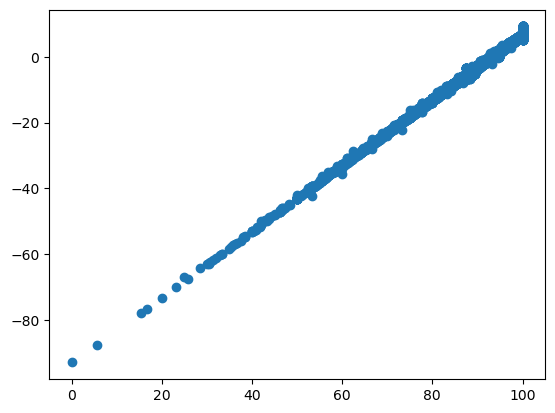

In [141]:
import matplotlib.pyplot as plt
plt.scatter(yTrain, epsilon)

In [142]:
#la proprete en gare n'est pas du tout caracterisée par la frequentation des gares